In [1]:
%load_ext autoreload
%autoreload 2  
%reload_ext autoreload

In [2]:
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy.special import softmax
from scipy.optimize import minimize

from bgspy.likelihood import SimplexModel
from bgspy.utils import load_pickle
from bgspy.optim import optim_plot
from bgspy.optim import equality_constraint_function, inequality_constraint_functions

/home/vsb/projects/bprime/bgspy/likelihood.py:6: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  import tqdm.autonotebook as tqdm


In [3]:
plt.show()
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 200
plt.style.use('./buffalo.mplstyle')

# MLE Diagnostics

### Merged Model

This is the simplest model, all CDS+phastcons+UTRs are merged into a single conserved feature type. The mixture with UTRs adds some complexity, since these are much less conserved.

In [53]:
fmd = load_pickle('../fits/hg38_cds_utrs_phastcons_simplex/old/model_data_1000000.pkl')

In [44]:
gm, Y, bgs_bins, features, bp = fmd['gm'], fmd['Y'], fmd['bgs_bins'], fmd['gm'], fmd['bp']

In [45]:
features = gm.features

In [46]:
gm.w, Y.shape

(array([1.00000000e-11, 6.30957344e-11, 3.98107171e-10, 2.51188643e-09,
        1.58489319e-08, 1.00000000e-07]),
 (2496, 2))

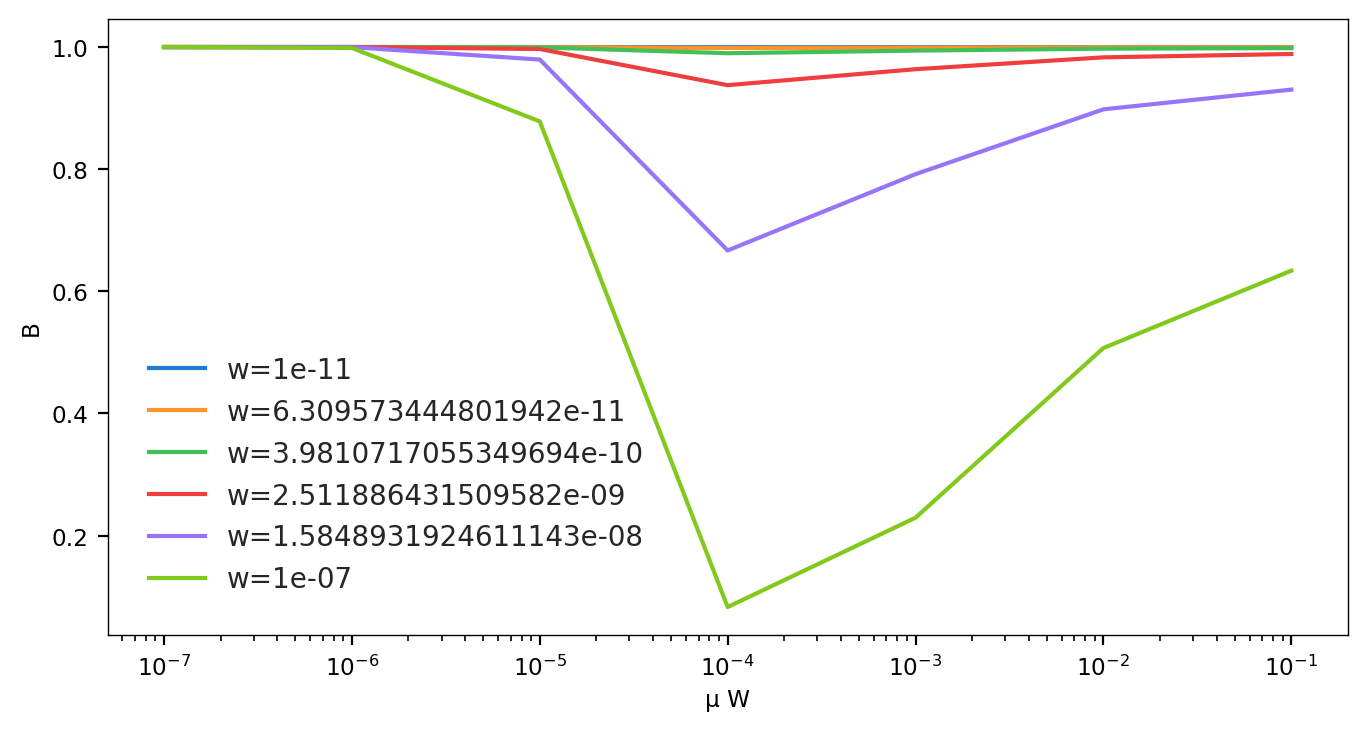

In [208]:
for i, w in enumerate(gm.w):
    plt.plot(gm.t, np.exp(bp[10, i, :, 1]), label=f"w={w}")
    plt.semilogx()
    plt.ylabel('B')
    plt.xlabel('μ W')
plt.legend()

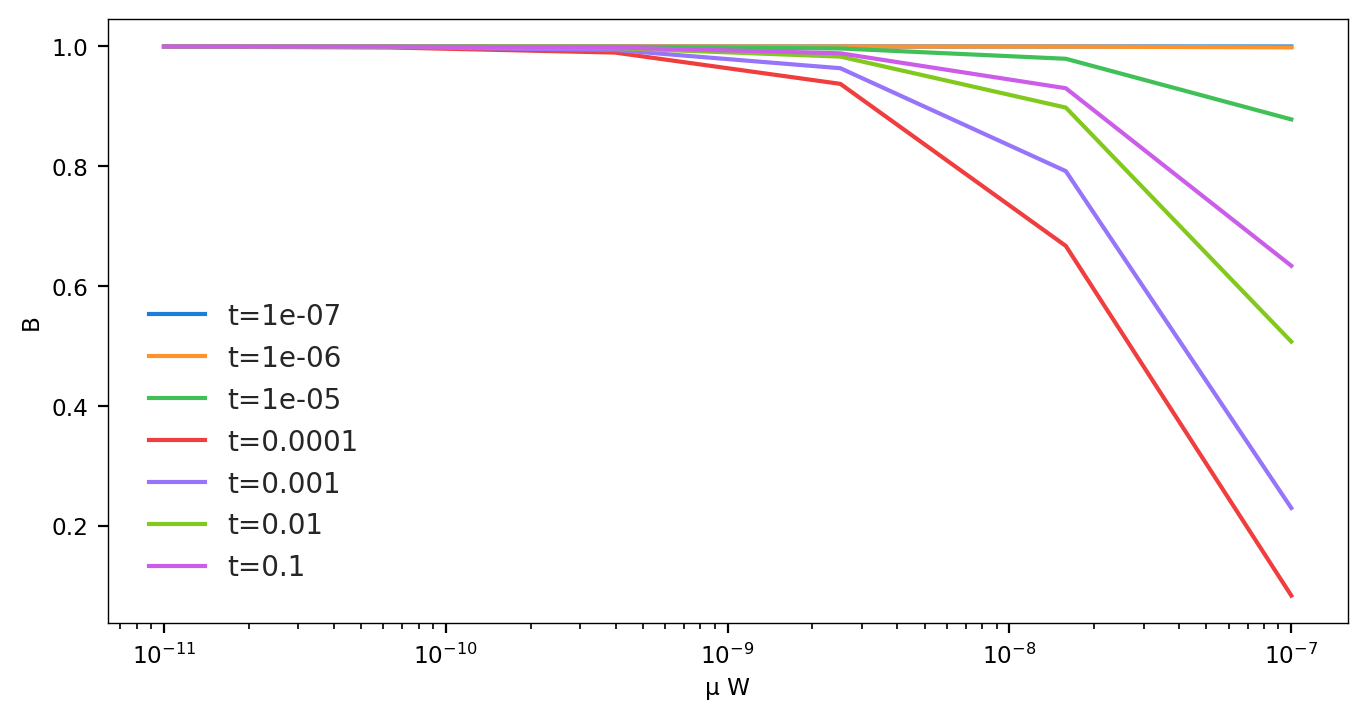

In [8]:
for i, t in enumerate(gm.t):
    plt.plot(gm.w, np.exp(bp[10, :, i, 1]), label=f"t={t}")
    plt.semilogx()
    plt.ylabel('B')
    plt.xlabel('μ W')
plt.legend()

### Experiments

In [47]:
from bgspy.likelihood import negll_simplex_full, negll_softmax_full
from functools import partial

In [48]:
MU_SCALE = 1e-8
PI_SCALE = 1e-4

def negll_simplex_rescaled(theta_scaled, grad, Y, B, w):
    mu = theta_scaled[1] * MU_SCALE
    pi0 = theta_scaled[0] * PI_SCALE
    theta = np.copy(theta_scaled)
    theta[1] = mu
    theta[0] = pi0
    return negll_softmax_full(theta, grad, Y, B, w)
    #return negll_simplex_full(theta, grad, Y, B, w)

def rescale_start(theta):
    theta_scaled = np.copy(theta)
    theta_scaled[0] = theta_scaled[0] / PI_SCALE
    theta_scaled[1] = theta_scaled[1] / MU_SCALE
    for i in range(2, len(theta)-2):
        theta_scaled[i] = np.random.normal(0, 1, 1)
    return theta_scaled


In [49]:
mb = SimplexModel(w=gm.w, t=gm.t, logB=bp, Y=Y,
                  bins=bgs_bins, features=features) 

In [50]:
#simplex_bounds = list(zip(*(rescale_start(mb.bounds()[0]), rescale_start(mb.bounds()[1]))))
simplex_bounds = list(zip(*(mb.bounds()[0], mb.bounds()[1])))
simplex_bounds[2:] = [(None, None)]*(len(simplex_bounds)-2)
#simplex_bounds = [(None, None)]*(len(simplex_bounds))
simplex_bounds

[(0.0004999999999999999, 0.004999999999999999),
 (9.000000000000006e-09, 4.999999999999999e-08),
 (None, None),
 (None, None),
 (None, None),
 (None, None),
 (None, None),
 (None, None),
 (None, None),
 (None, None),
 (None, None),
 (None, None),
 (None, None),
 (None, None),
 (None, None),
 (None, None),
 (None, None),
 (None, None),
 (None, None),
 (None, None),
 (None, None),
 (None, None),
 (None, None)]

In [12]:
import multiprocessing
import tqdm
def opt(start):
    return minimize(partial(negll_softmax_full, grad=None, Y=Y, B=bp, w=gm.w), 
             bounds=simplex_bounds, 
             options={
                 #'maxiter': 1e6,
                 #'xatol': 1e-8,
                 #'adaptive': True,
                 #'fatol':1000
             },
             x0=start, 
             method='L-BFGS-B'
             #method='TNC',
             #method='Nelder-Mead'                   
            )

In [13]:
%%time 
NS = 1000
with multiprocessing.Pool(70) as p:
    bfgs = list(tqdm.tqdm(p.imap(opt, [mb.random_start() for r in range(NS)]), total=NS))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [17:01<00:00,  1.02s/it]


CPU times: user 3.62 s, sys: 14.7 s, total: 18.4 s
Wall time: 17min 16s


In [15]:
nlls = np.array([r.fun for r in bfgs])
nll_idx = np.argsort(nlls)
min_i = nll_idx[1]
nlls[min_i]

323821632198.278

In [17]:
a = bfgs

In [160]:
nlls = [r.fun for r in a]
nll_idx = np.argsort(nlls)
min_i = nll_idx[0]
nlls[min_i]

322738283049.4047

In [18]:
a[nll_idx[1]].message

'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'

In [19]:
nlls = [r.fun for r in a]
min_i = np.argmin(nlls)
nlls[min_i]

323801121624.9068

In [20]:
nlls = [r.fun for r in a]
nll_idx = np.argsort(nlls)
min_i = nll_idx[0]
nlls[min_i]

323801121624.9068

In [21]:
#a[min_i].x[0] * MU_SCALE, a[min_i].x[1] * PI_SCALE
a[min_i].x[0], a[min_i].x[1]

(0.001533083172058827, 2.6506112791649518e-08)

In [22]:
a[min_i].x[2:].reshape(mb.nt, mb.nf)

array([[ 0.43861248, -4.21680667, -0.41721338],
       [ 0.15517384, -3.85119856, -0.37498927],
       [ 0.12812948, -3.34786117, -0.38944758],
       [-1.04376041,  1.24324774, -0.09469992],
       [-0.51169828,  3.89885981,  0.34790112],
       [ 0.04601103,  3.45602202,  0.10424261],
       [ 1.79367388,  3.87962057,  1.86482758]])

In [23]:
a[nll_idx[0]].x

array([ 1.53308317e-03,  2.65061128e-08,  4.38612480e-01, -4.21680667e+00,
       -4.17213380e-01,  1.55173844e-01, -3.85119856e+00, -3.74989266e-01,
        1.28129483e-01, -3.34786117e+00, -3.89447575e-01, -1.04376041e+00,
        1.24324774e+00, -9.46999244e-02, -5.11698278e-01,  3.89885981e+00,
        3.47901120e-01,  4.60110345e-02,  3.45602202e+00,  1.04242613e-01,
        1.79367388e+00,  3.87962057e+00,  1.86482758e+00])

In [24]:
np.seterr(under='ignore')
np.round(softmax(a[nll_idx[0]].x[2:].reshape(mb.nt, mb.nf), axis=0), 2)

array([[0.13, 0.  , 0.06],
       [0.1 , 0.  , 0.06],
       [0.1 , 0.  , 0.06],
       [0.03, 0.03, 0.08],
       [0.05, 0.37, 0.12],
       [0.09, 0.24, 0.09],
       [0.51, 0.36, 0.54]])

In [25]:
np.round(softmax(a[nll_idx[1]].x[2:].reshape(mb.nt, mb.nf), axis=0), 2)

array([[0.22, 0.13, 0.21],
       [0.22, 0.18, 0.33],
       [0.22, 0.12, 0.18],
       [0.02, 0.02, 0.02],
       [0.06, 0.15, 0.04],
       [0.11, 0.15, 0.09],
       [0.15, 0.23, 0.14]])

In [26]:
np.round(softmax(a[nll_idx[5]].x[2:].reshape(mb.nt, mb.nf), axis=0), 2)

array([[0.2 , 0.08, 0.18],
       [0.2 , 0.08, 0.25],
       [0.19, 0.07, 0.15],
       [0.03, 0.02, 0.02],
       [0.06, 0.11, 0.05],
       [0.12, 0.2 , 0.1 ],
       [0.2 , 0.43, 0.26]])

In [170]:
dfes = []
for i in range(100):
    dfes.append(softmax(a[nll_idx[i]].x[2:].reshape(mb.nt, mb.nf), axis=0))

alpha = 0.05
#np.round(np.quantile(np.stack(dfes), (alpha/2, 1-alpha/2), axis=0), 3)
np.round(np.mean(np.stack(dfes), axis=0), 3)

array([[0.177, 0.037, 0.135],
       [0.182, 0.036, 0.131],
       [0.113, 0.024, 0.095],
       [0.011, 0.007, 0.014],
       [0.04 , 0.231, 0.043],
       [0.118, 0.363, 0.162],
       [0.358, 0.303, 0.419]])

In [171]:
mb.features

['cds', 'phastcons', 'utr']

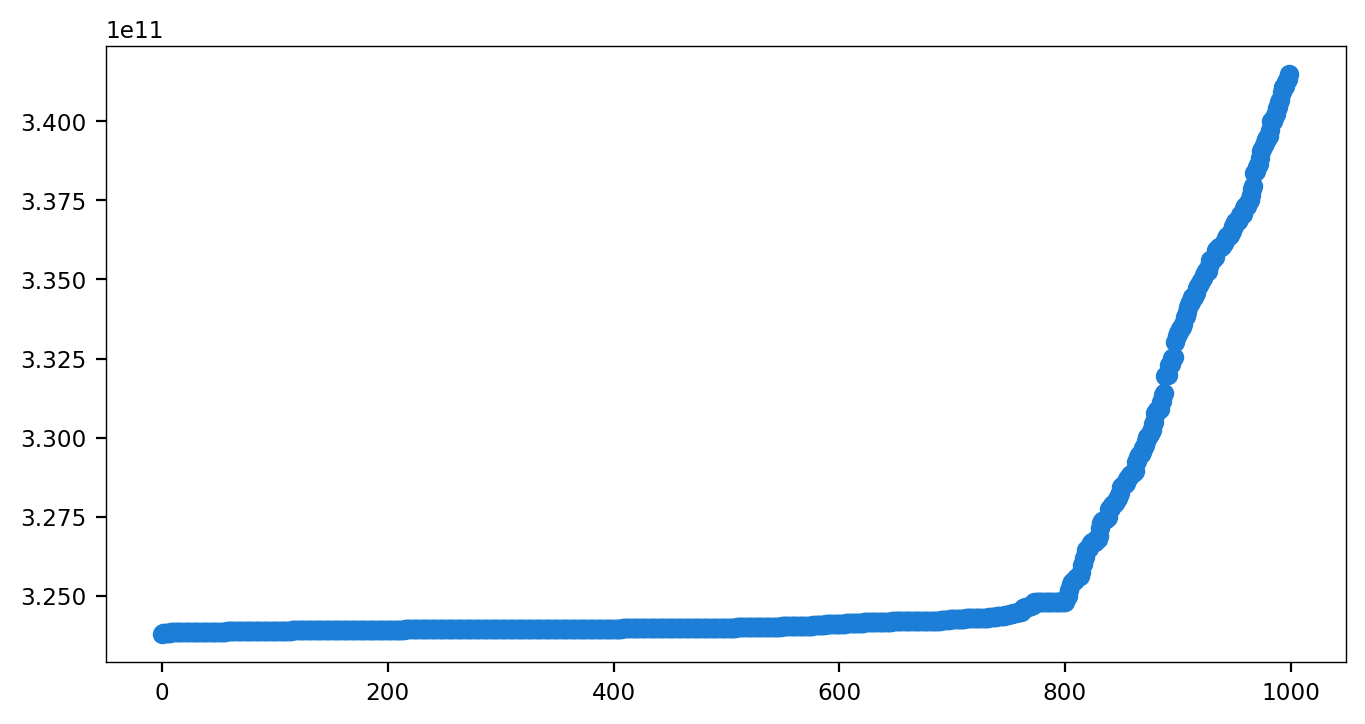

In [27]:
plt.scatter(np.arange(len(nlls)), np.sort(nlls))

Text(0.5, 0, 'rank')

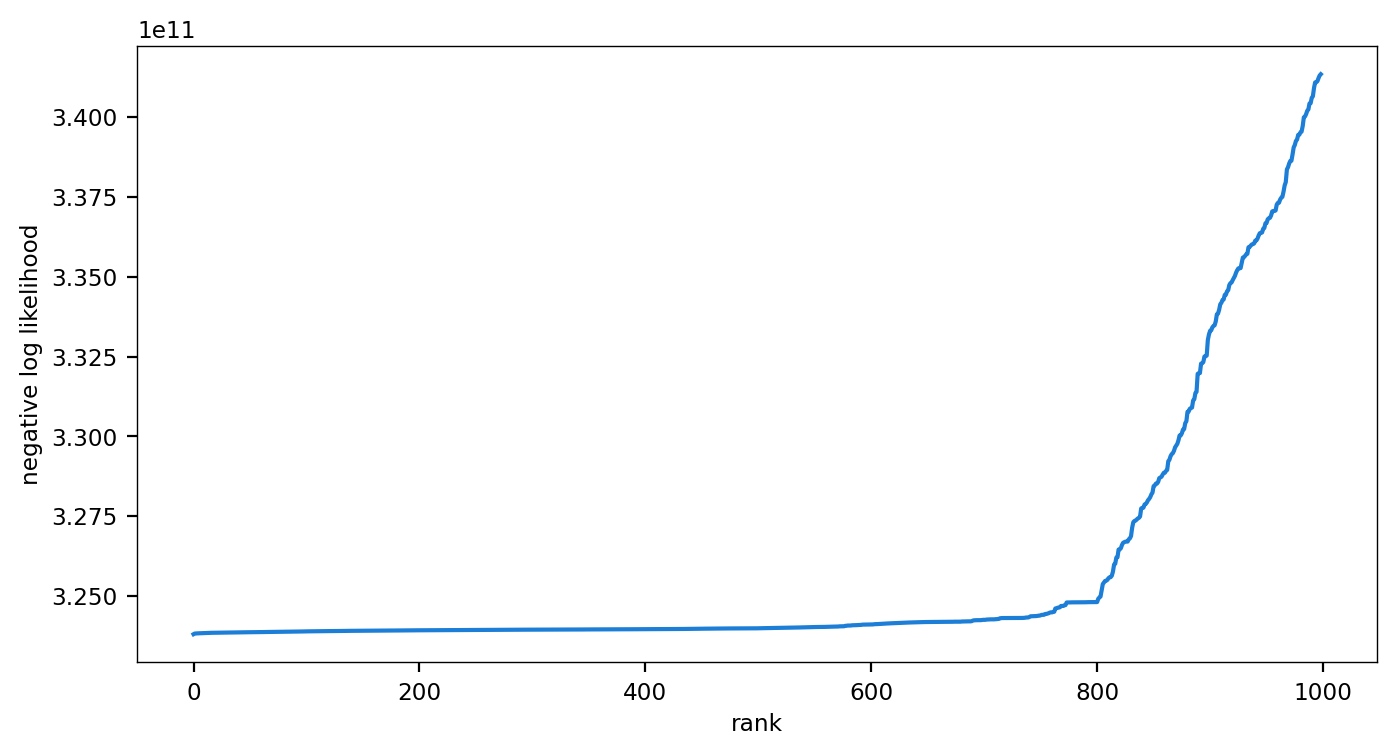

In [28]:
thresh = 1
plt.plot(np.arange(len(nlls))[:-thresh], np.sort(nlls)[:-thresh])
plt.ylabel('negative log likelihood')
plt.xlabel('rank')

In [211]:
a = mb.optim.thetas_
nlls = mb.optim.nlls_

In [ ]:
a.

(100, 23)

Text(0.5, 0, 'rank')

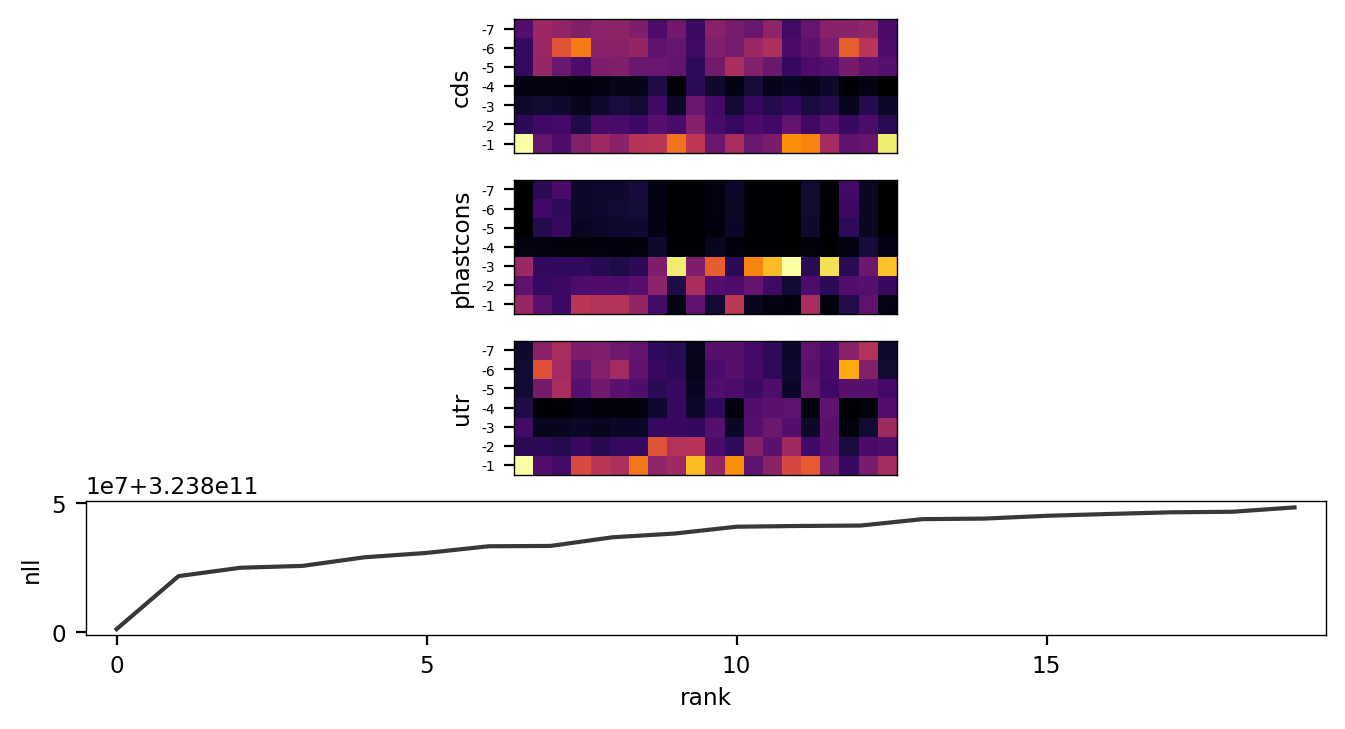

In [31]:
top_n = 20

dfes = []
for i in range(top_n):
    dfes.append(softmax(a[nll_idx[i]].x[2:].reshape(mb.nt, mb.nf), axis=0))
    #dfes.append(softmax(a[i, :][2:].reshape(mb.nt, mb.nf), axis=0))

dfes = np.stack(dfes)
#dfes = dfes - np.mean(dfes, axis=0)

fig, ax = plt.subplots(ncols=1, nrows=mb.nf + 1, sharex=True)

for i in range(mb.nf):
    ax[i].imshow(dfes[:, :, i].T, cmap='inferno')
    ax[i].set_ylabel(f"{features[i]}")
    ax[i].set_yticks(np.arange(mb.nt), np.log10(mb.t).astype(int))
    ax[i].xaxis.set_visible(False)
    ax[i].tick_params(axis='y', which='major', labelsize=5)
thresh = 1
i += 1
# ax[i].scatter(np.arange(len(nlls))[:top_n], np.sort(nlls)[:top_n], 
#               c=[{True: 'black', False: 'red'}[x.success] for x in a][:top_n],
#              s=2)
ax[i].plot(np.arange(len(nlls))[:top_n], np.sort(nlls)[:top_n], c='0.22')
ax[i].set_ylabel('nll')
ax[i].set_xlabel('rank')


In [32]:
mb.theta_ = a[min_i].x

In [38]:
def convert_softmax(theta_sm):
    theta = np.copy(theta_sm)
    theta[2:] = softmax(theta[2:].reshape(mb.nt, mb.nf), axis=0).flat
    return theta

#mb.theta_ = mb.random_start() #convert_softmax(a[-1].x)
mb.theta_ = convert_softmax(a[min_i].x)
mb.nll_ = nlls[min_i]

(<Figure size 1600x800 with 1 Axes>, <AxesSubplot: >)

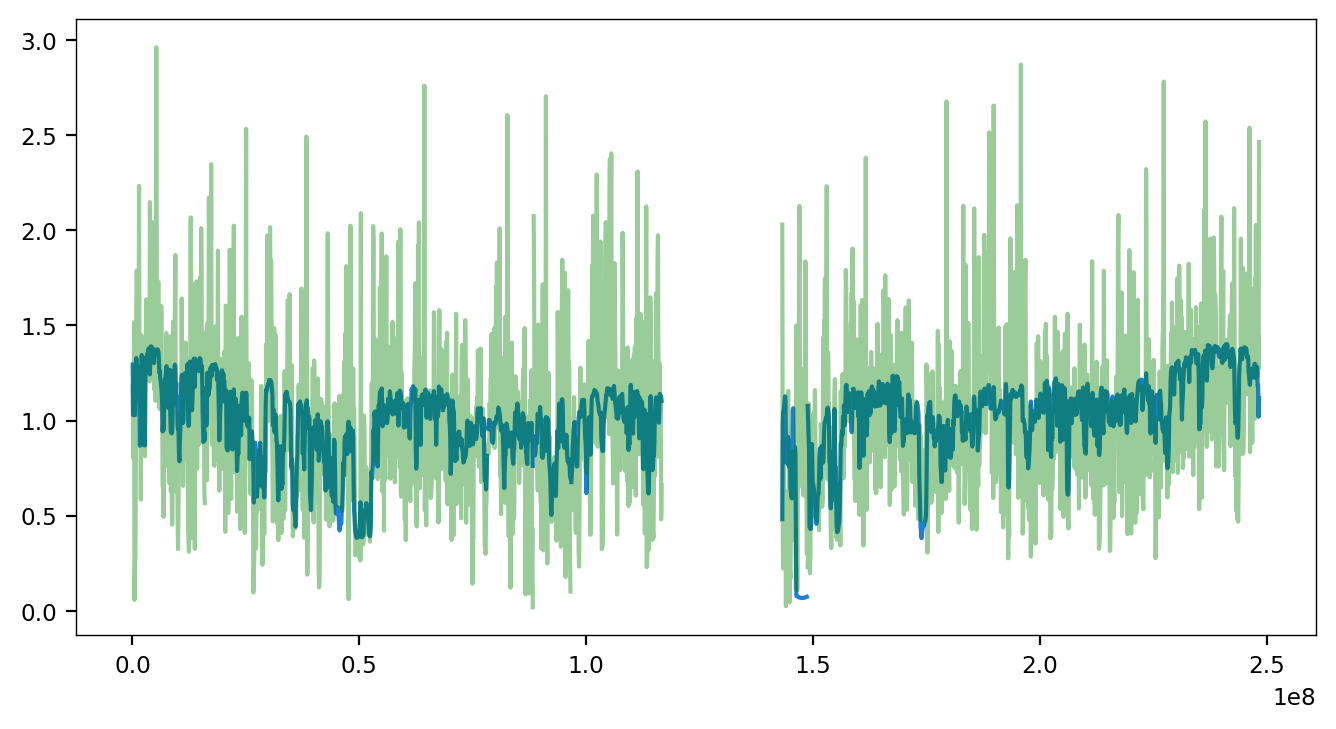

In [39]:
mb.predict_plot('chr1')

In [40]:
mb

MLE (interpolated w): 6 x 7 x 3
  w grid: [1.000e-11 6.310e-11 3.981e-10 2.512e-09 1.585e-08 1.000e-07] (before interpolation)
  t grid: [1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]

Simplex model ML estimates:
negative log-likelihood: 323801121624.9068
π0 = 0.001533083172058827
μ = 2.6506112791649518e-08
R² = 48.5225
W = 
          cds    phastcons    utr
------  -----  -----------  -----
1e-07   0.131        0      0.055
1e-06   0.098        0      0.058
1e-05   0.096        0      0.057
0.0001  0.03         0.026  0.076
0.001   0.051        0.371  0.119
0.01    0.088        0.238  0.093
0.1     0.507        0.364  0.542

In [80]:
mb.theta_ = convert_softmax(bfgs[min_i].x)

(<Figure size 1600x800 with 1 Axes>, <AxesSubplot: >)

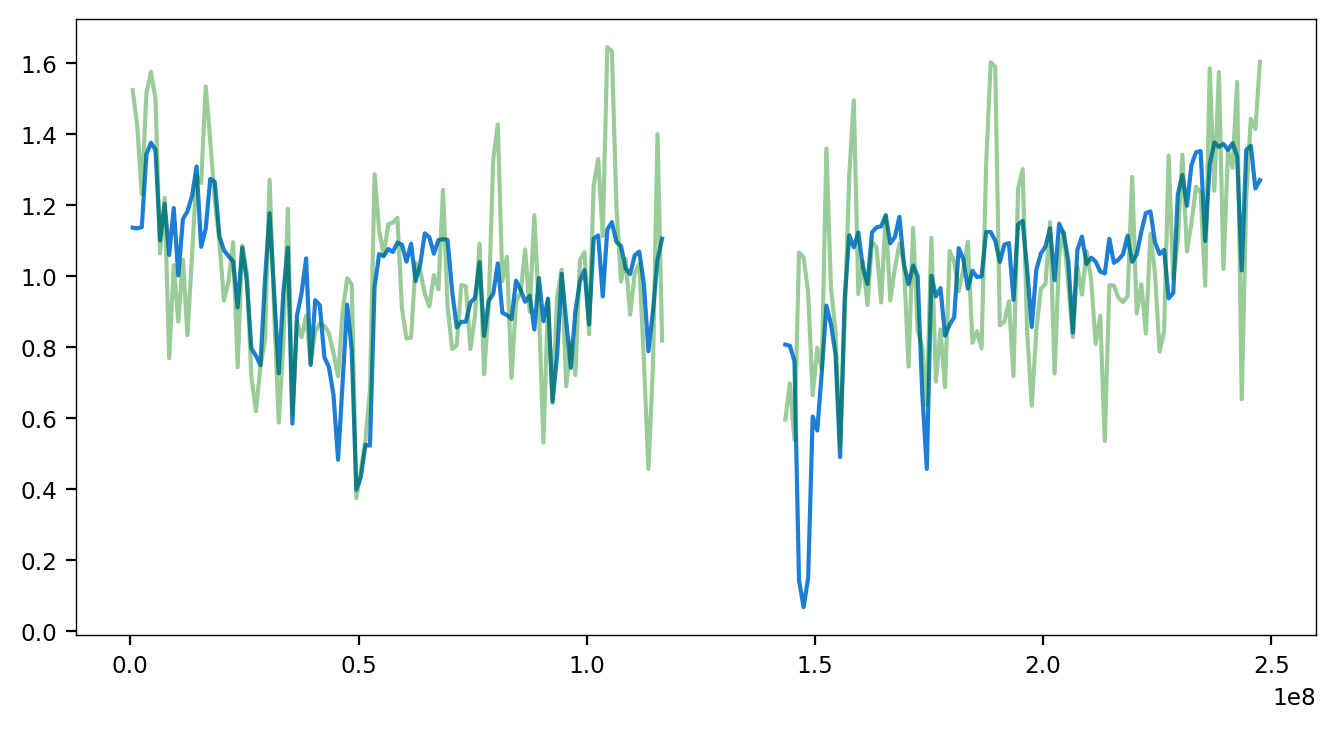

In [81]:
mb.predict_plot('chr1')


(<Figure size 1600x800 with 1 Axes>,
 <AxesSubplot: xlabel='predicted $\\hat{\\pi}$', ylabel='residuals'>)

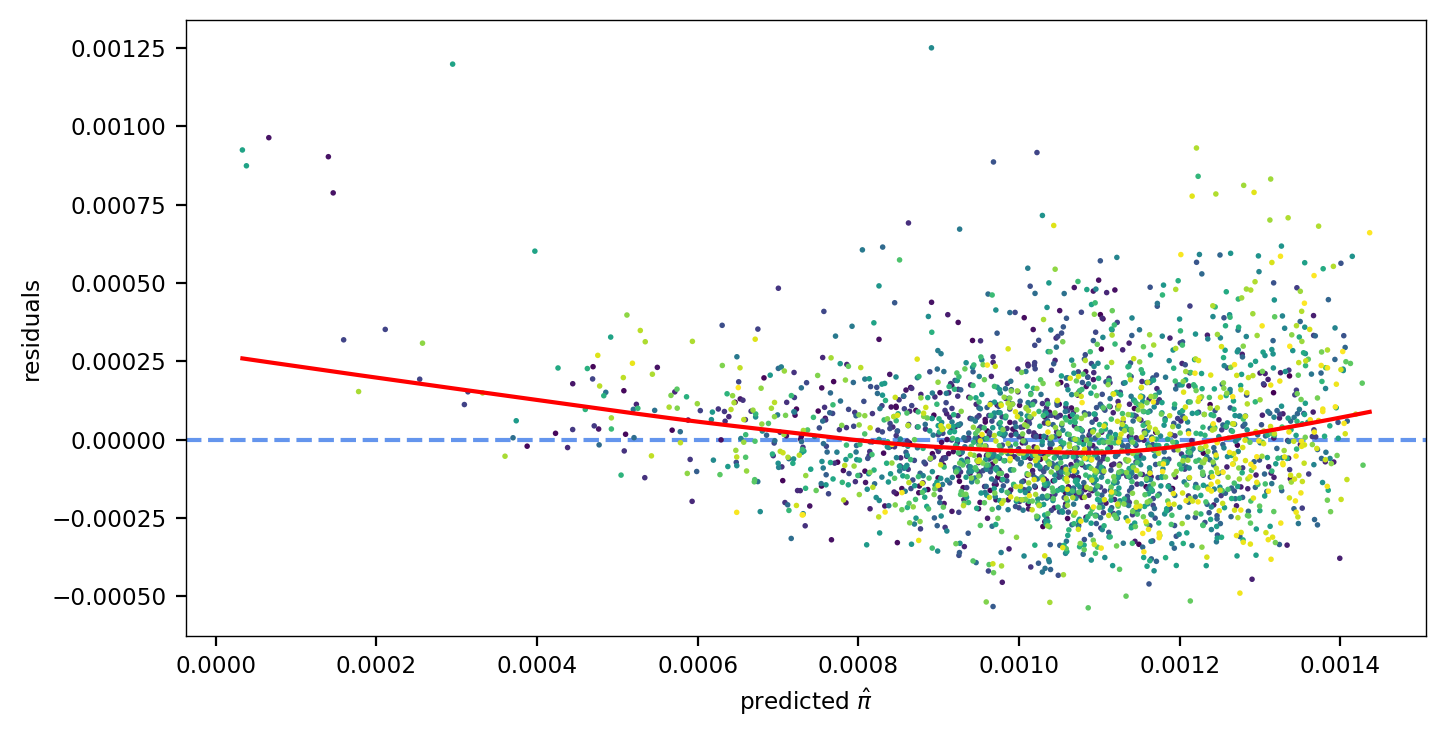

In [82]:
mb.resid_fitted_plot()
#plt.semilogx()
#plt.xlim(1e-9, 1e-1)


(<Figure size 1600x800 with 1 Axes>, <AxesSubplot: >)

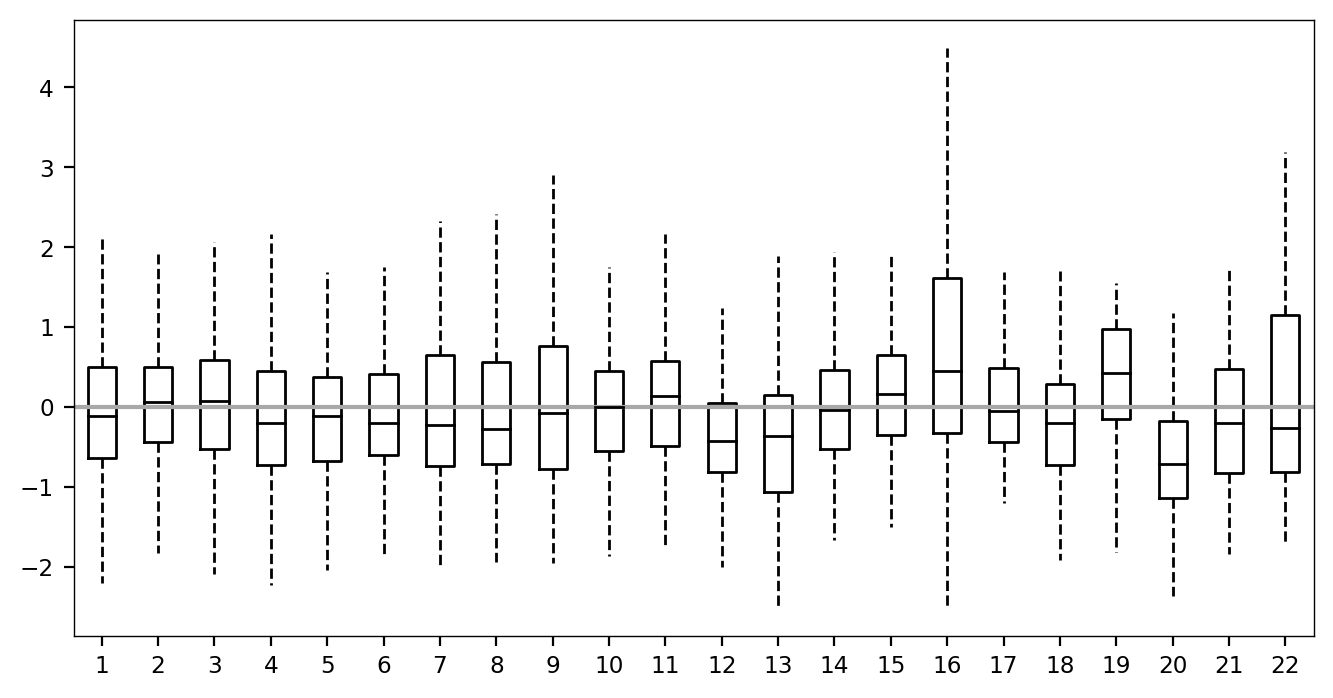

In [170]:
mb.chrom_resid_plot()

In [173]:
mb.nll_ = nlls[min_i]
mb

MLE (interpolated w): 6 x 7 x 3
  w grid: [1.000e-11 6.310e-11 3.981e-10 2.512e-09 1.585e-08 1.000e-07] (before interpolation)
  t grid: [1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]

Simplex model ML estimates:
negative log-likelihood: 323801121624.9068
π0 = 0.001533083172058827
μ = 2.6506112791649518e-08
R² = 68.1189
W = 
          cds    phastcons    utr
------  -----  -----------  -----
1e-07   0.131        0      0.055
1e-06   0.098        0      0.058
1e-05   0.096        0      0.057
0.0001  0.03         0.026  0.076
0.001   0.051        0.371  0.119
0.01    0.088        0.238  0.093
0.1     0.507        0.364  0.542

In [209]:
%%time 
mb.fit(ncores=70, starts=100, start_pi0=0.0015, start_mu=3e-8, algo='GN_ISRES')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [56:34<00:00, 33.95s/it]


CPU times: user 785 ms, sys: 19 s, total: 19.8 s
Wall time: 56min 54s


In [210]:
mb

MLE (interpolated w): 6 x 7 x 3
  w grid: [1.000e-11 6.310e-11 3.981e-10 2.512e-09 1.585e-08 1.000e-07] (before interpolation)
  t grid: [1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]

Simplex model ML estimates:
negative log-likelihood: 322730856130.1677
π0 = 0.001548282636298154
μ = 3.3456171082384254e-08
R² = 68.3494
W = 
          cds    phastcons    utr
------  -----  -----------  -----
1e-07   0.083        0.002  0.175
1e-06   0.865        0      0.025
1e-05   0.029        0      0.029
0.0001  0            0      0.039
0.001   0            0.238  0.115
0.01    0            0.359  0.067
0.1     0.024        0.402  0.549

In [14]:
m_b.optim

OptimResult
  termination code: xtol reached
  stats: {'xtol reached': 1992, 'max eval': 8} (prop success: 100.0%)
  negative log-likelihood = 322778981134.79486
  theta = [1.58288477e-03 3.00449198e-08 3.60169419e-04 5.06109943e-04
 2.42576328e-05 2.81284967e-04 2.14794012e-01 8.35385118e-02
 7.00650041e-01]

In [11]:
m_b

MLE (interpolated w): 6 x 7 x 1
  w grid: [1.000e-11 6.310e-11 3.981e-10 2.512e-09 1.585e-08 1.000e-07] (before interpolation)
  t grid: [1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]

Simplex model ML estimates:
negative log-likelihood: 322778994608.46765
π0 = 0.001582883595483872
μ = 4.496758587745205e-08
R² = 66.6214
W = 
          undefined
------  -----------
1e-07         0.313
1e-06         0.018
1e-05         0
0.0001        0
0.001         0.142
0.01          0.061
0.1           0.465

In [50]:
m_b

MLE (interpolated w): 6 x 7 x 1
  w grid: [1.000e-11 6.310e-11 3.981e-10 2.512e-09 1.585e-08 1.000e-07] (before interpolation)
  t grid: [1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]

Simplex model ML estimates:
negative log-likelihood: 322778986520.9623
π0 = 0.0015824358718647073
μ = 3.281030904802272e-08
R² = 66.6248
W = 
          undefined
------  -----------
1e-07         0.071
1e-06         0.014
1e-05         0
0.0001        0
0.001         0.196
0.01          0.079
0.1           0.639

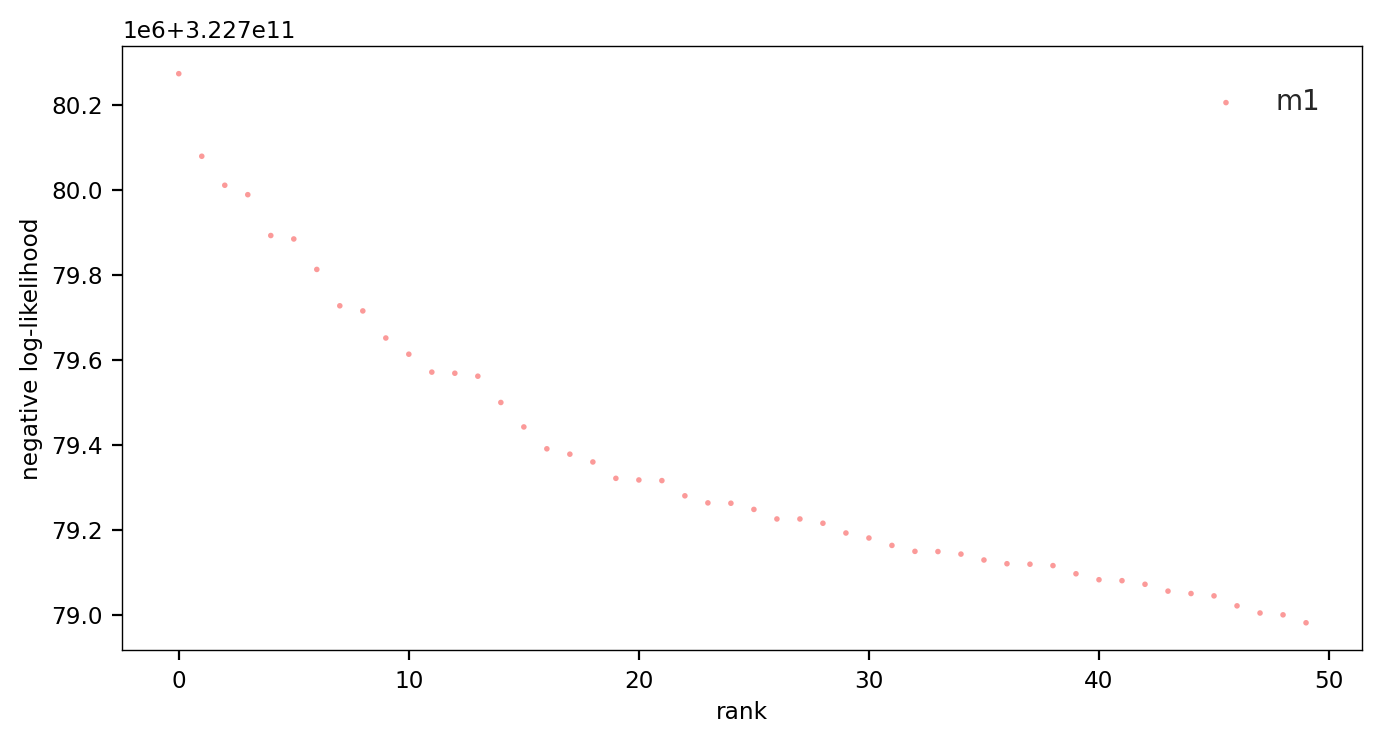

In [17]:
optim_plot(m1=mb.optim)

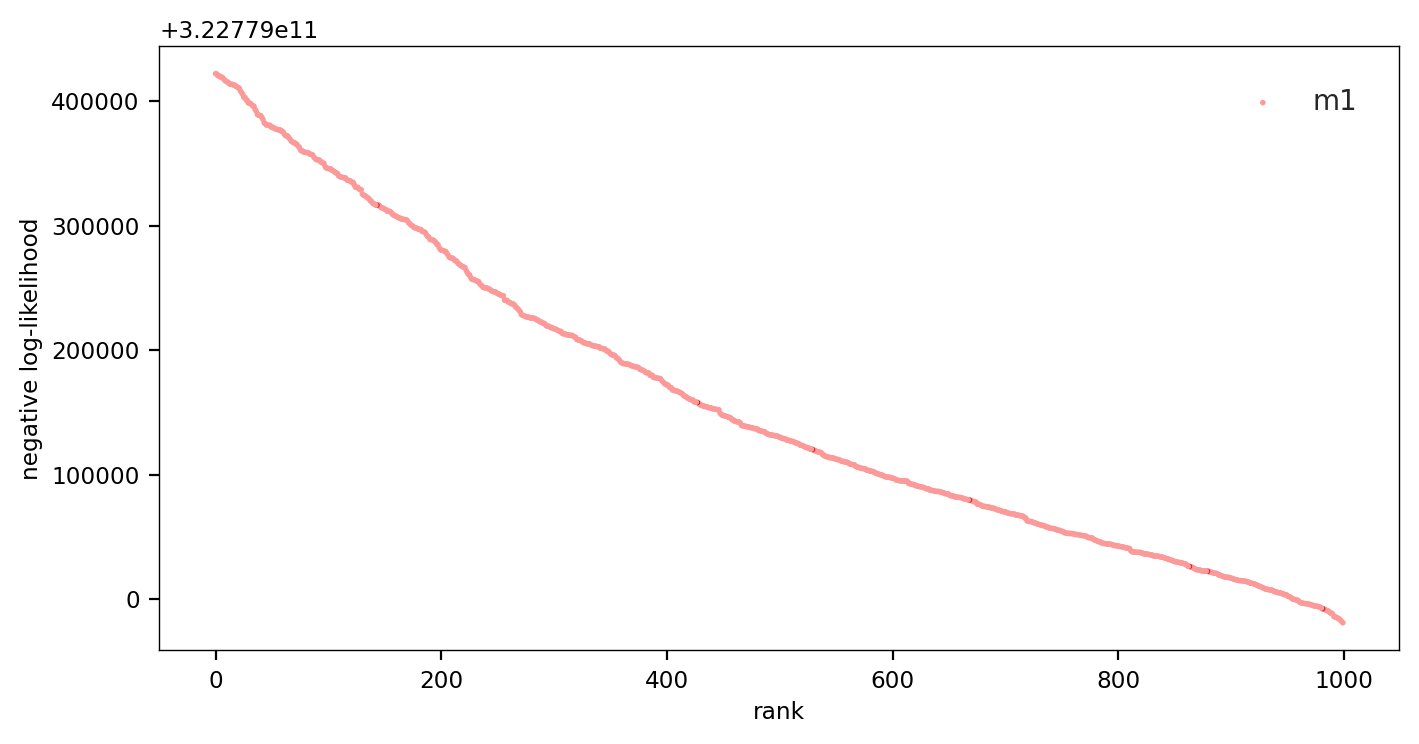

In [13]:
optim_plot(m1=m_b.optim)

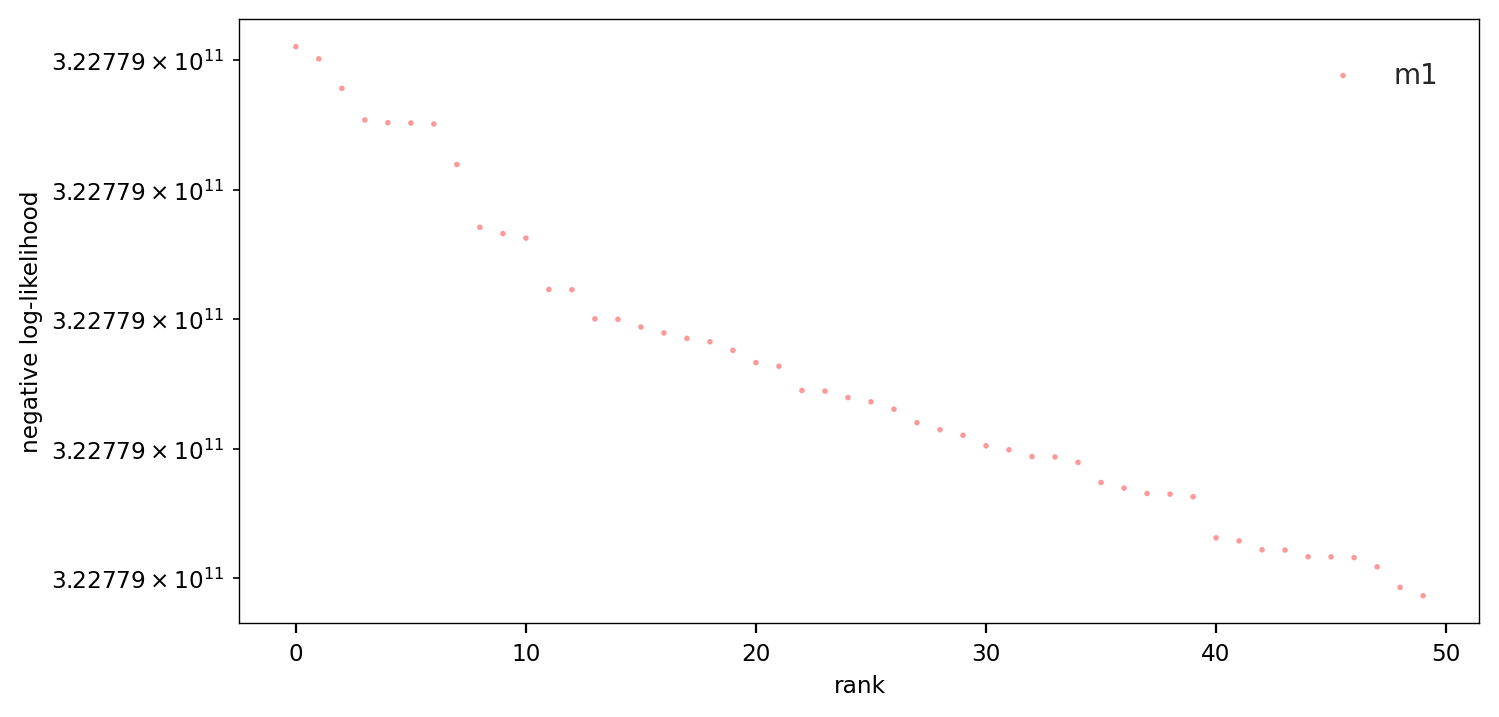

In [56]:
optim_plot(m1=m_b.optim)

In [15]:
m_b.fit(ncores=50, starts=1, start_pi0=0.0015, start_mu=3e-8, algo='GN_ISRES')

  0%|          | 0/1 [00:00<?, ?it/s]

> /home/vsb/projects/bprime/bgspy/optim.py(188)nlopt_simplex_worker()
    186     log10_mu_bounds = bounds[0][1], bounds[1][1]  # TODO CHECK
    187     __import__('pdb').set_trace()
--> 188     hl, hu = inequality_constraint_functions(nt, nf, mu=mu, 
    189                                              log10_mu_bounds=log10_mu_bounds)
    190     # tolerances for inequality constraint



ipdb>  log10_mu_bounds


(1e-11, 1e-07)


ipdb>  exit


BdbQuit: 

### CDS + UTRs + Phastcons Model

In [ ]:
fd = load_pickle('../fits/hg38_cds_utrs_phastcons_simplex/model_data.pkl')
gm, Y, bgs_bins, features, bp = fd['gm'], fd['Y'], fd['bgs_bins'], fd['gm'], fd['bp']

In [32]:
10**np.array(tuple(np.log10((0.0005, 0.005))))

array([0.0005, 0.005 ])

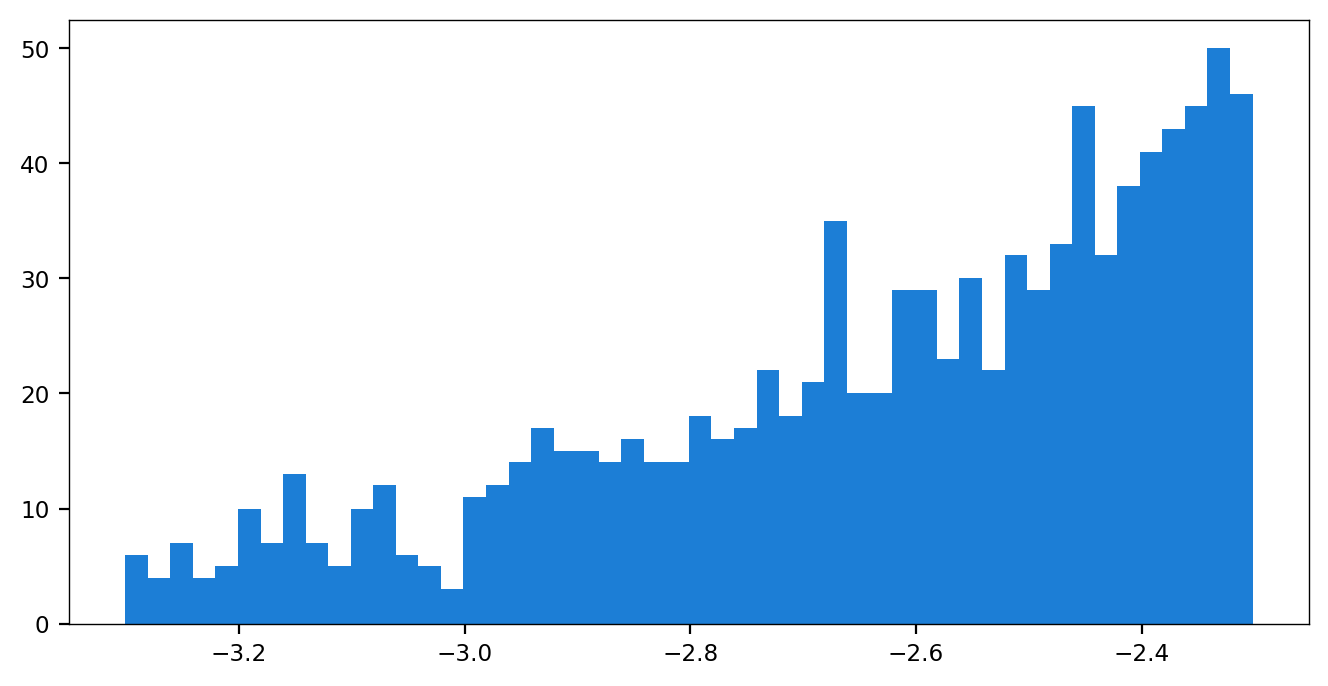

In [44]:
_ = plt.hist(np.log10([m_b.random_start()[0] for x in range(1000)]), 50)

In [39]:
from bgspy.data import pi_from_pairwise_summaries
pi_from_pairwise_summaries(Y.sum(axis=0))

0.001052746703898515

In [18]:
m_b

MLE (interpolated w): 6 x 7 x 1
  w grid: [1.000e-11 6.310e-11 3.981e-10 2.512e-09 1.585e-08 1.000e-07] (before interpolation)
  t grid: [1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]

Simplex model ML estimates:
negative log-likelihood: 322791293316.3191
π0 = 0.0015787476785369746
μ = 6.407820745658771e-08
R² = 66.2317
W = 
          undefined
------  -----------
1e-07         0.022
1e-06         0.393
1e-05         0.127
0.0001        0
0.001         0.064
0.01          0.112
0.1           0.281

In [21]:
m_b

MLE (interpolated w): 6 x 7 x 3
  w grid: [1.000e-11 6.310e-11 3.981e-10 2.512e-09 1.585e-08 1.000e-07] (before interpolation)
  t grid: [1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]

Simplex model ML estimates:
negative log-likelihood: 322741693444.99133
π0 = 0.001559728773284351
μ = 3.855877895183788e-08
R² = 67.8068
W = 
          cds    phastcons    utr
------  -----  -----------  -----
1e-07   0.32         0.055  0.241
1e-06   0.228        0.007  0.202
1e-05   0.008        0.003  0.133
0.0001  0.001        0.001  0.02
0.001   0.001        0.148  0.063
0.01    0.266        0.414  0.196
0.1     0.177        0.372  0.146

In [10]:
%%time
m_b.fit(ncores=70, starts=100, algo='GN_ISRES')

  0%|          | 0/100 [00:00<?, ?it/s]

Process ForkPoolWorker-140:
Process ForkPoolWorker-136:
Process ForkPoolWorker-117:
Process ForkPoolWorker-88:
Process ForkPoolWorker-125:


KeyboardInterrupt: 